# Merian project Part 1

## *Explore the morphology of dwarf galaxies in H$\alpha$ using the Merian Survey data*

- [x] Parse the photo-z catalog in COSMOS, and understand how many of them have spec-z
- [ ] Generate cutout, and study how to make a beautiful image
- [x] Study how to use Abby's code
- [ ] Possible Jellyfish project

**Prerequisites**
- Need to install `reproject` and `photutils` and `cmasher`

In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if not IN_COLAB:
    if not os.path.exists("../../../_static/ObsAstroData/"):
        os.makedirs("../../../_static/ObsAstroData/")
    os.chdir('../../../_static/ObsAstroData/')
os.chdir('./merian/')

## Part 1: Understand the Merian survey

Some text about the Merian survey goes here, e.g., filters, H-alpha, and why we can catch galaxies in the redshift range.

We start by exploring the color $N708-i$ as a function of galaxy redshift. This color roughly represents how much H$\alpha$ is emitted by the galaxy. 

In [7]:
cat = Table.read('./cosmos_Merian_DR1_photoz_v1.0.fits')
cat = cat[cat['z_desi'] != -99.0]
cat = cat[cat['good_desi']] # ensure good DESI spec-z
cat = cat[cat['z_desi'] < 2]

zp = 31.4
for filt in ['g', 'r', 'i', 'N708', 'N540']:
    cat[f'mag_{filt}'] = zp - 2.5 * np.log10(cat[f'{filt}_gaap1p0Flux_Merian'])
z_spec = cat['z_desi']

/var/folders/mq/3_39x3fx4wsghv_g8p9dkm9m0000gn/T/ipykernel_42902/1238779004.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_facecolor('none')


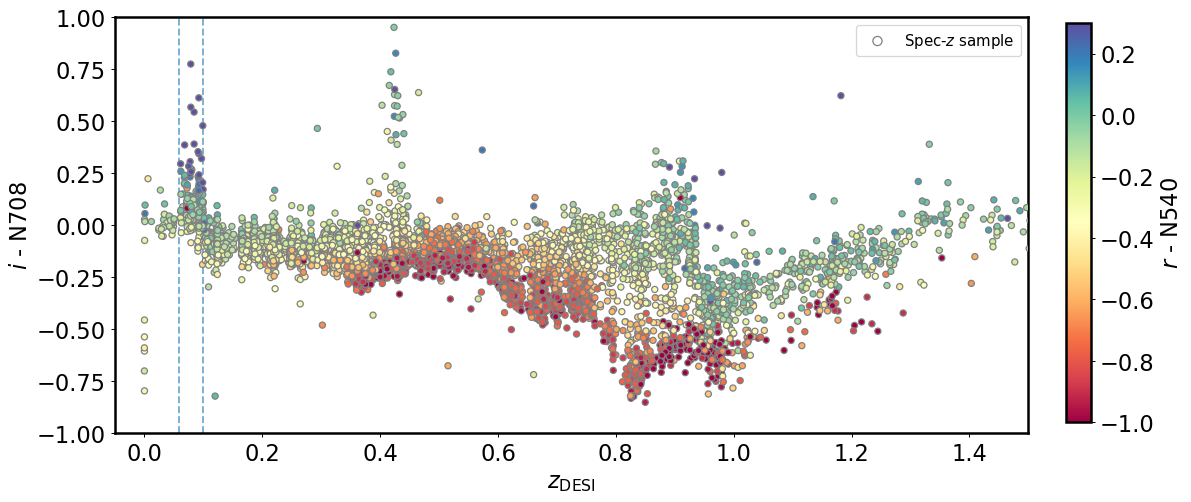

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

plt.sca(axes)
sct = plt.scatter(cat['z_desi'], cat['mag_i'] - cat['mag_N708'], 
                  c=cat['mag_r'] - cat['mag_N540'],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, s=24,
                  edgecolors='gray', zorder=30, label='Spec-$z$ sample')

plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-1, 1.0)
plt.xlim(-0.05, 1.5)
plt.xlabel('$z_\mathrm{DESI}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(loc='upper right', fontsize=12, scatterpoints=1, frameon=True, markerscale=1.5)
leg.legendHandles[0].set_facecolor('none')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540')
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)
# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/manual_gaap_excess_plot_{hsc_type}.png', 
#             dpi=100, bbox_inches='tight')

**We can ask students to explain why they see two spikes, one at z=0.05-0.10, and the other one at about z=0.45. Then ask them how to break this degeneracy (i.e., by introducing N540).**

In [9]:
cat_inband = cat[(z_spec < 0.11) & (z_spec > 0.05) & (cat['mag_i'] < 21.5)]
cat_inband['ssfr_1p0'] = cat_inband['sfr_1p0'] - cat_inband['mass_1p0']

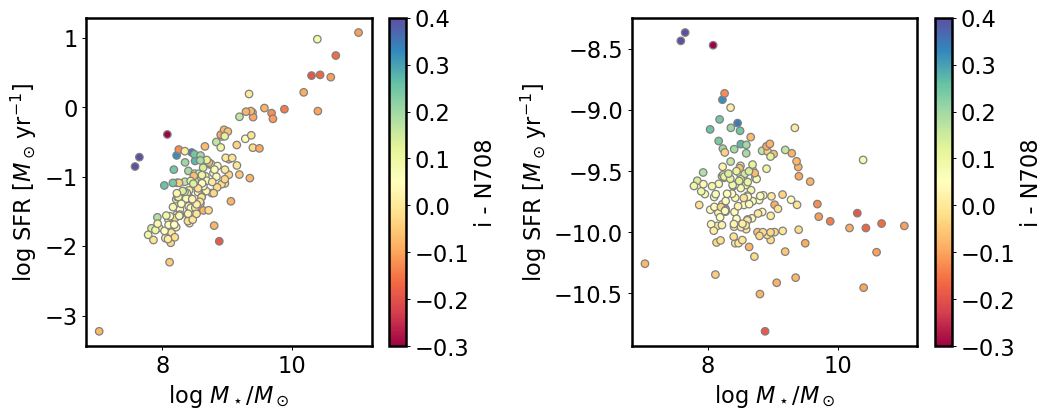

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax1)
plt.scatter(cat_inband['mass_1p0'], cat_inband['sfr_1p0'], 
            c=cat_inband['mag_i'] - cat_inband['mag_N708'], 
            ec='gray', cmap='Spectral', vmin=-0.3, vmax=0.4)
plt.colorbar(label='i - N708')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel(r'$\log\,\mathrm{SFR}\ [M_\odot\,\mathrm{yr}^{-1}]$')

plt.sca(ax2)
plt.scatter(cat_inband['mass_1p0'], cat_inband['ssfr_1p0'], 
            c=cat_inband['mag_i'] - cat_inband['mag_N708'], 
            ec='gray', cmap='Spectral', vmin=-0.3, vmax=0.4)
plt.colorbar(label='i - N708')
plt.xlabel(r'$\log\,M_\star/M_\odot$')
plt.ylabel(r'$\log\,\mathrm{SFR}\ [M_\odot\,\mathrm{yr}^{-1}]$')

plt.tight_layout()

## Is there any other catalog-level thing we can play with?

### NOT TESTED YET: Generate cutout

---

# Part 2: Pretty pictures!!

In [12]:
from astropy.io import fits
from utils import pad_psf, show_image

In [13]:
merian = Table.read("./merian_dr1_specz_inband_lowmass_allbands.csv")
cutout_dir = "./cutouts/"

In [14]:
i = 1850
obj = merian[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
cname = obj['cname']

In [64]:
# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merim.fits"))[1].data

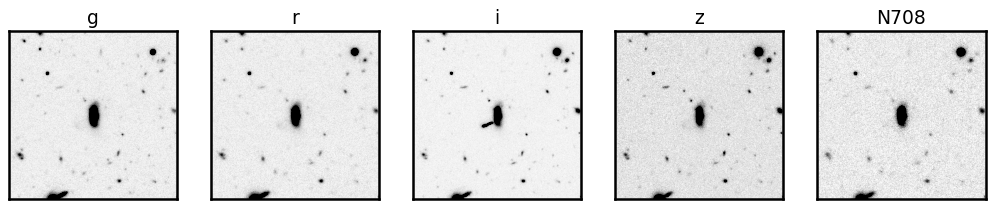

In [61]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys')
    axes[i].set_title(band, fontsize=15)

**Black & White images are boring... let's make them colorful**

In [62]:
from astropy.visualization import make_lupton_rgb
from ipywidgets import interact, FloatSlider

In [42]:
def update_rgb(stretch=1.0, Q=5.0):
    rgb = make_lupton_rgb(cutouts['i'], cutouts['r'], cutouts['g'], stretch=stretch, Q=Q)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb, origin='lower')
    plt.axis('off')
    plt.title(f"stretch={stretch:.2f}, Q={Q:.2f}")
    plt.show()

# Add interactive sliders
interact(update_rgb, 
         stretch=FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1, description='Stretch'), 
         Q=FloatSlider(value=5.0, min=0.1, max=10.0, step=0.1, description='Q'));

interactive(children=(FloatSlider(value=0.5, description='Stretch', max=2.0, min=0.1), FloatSlider(value=5.0, …

In [65]:
cutout_headers = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "", f"{cname}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, f"{cname}_N708_merpsf.fits"))[0].data

In [66]:
psf_shape = np.max(np.array([i.shape for i in psfs.values()]), 0)
cutout_shape = np.min(np.array([i.shape for i in cutouts.values()]), 0)

# make all the psfs the same shape
for i in psfs.keys():
    psfs[i] = pad_psf(psfs[i], psf_shape)

In [67]:
## Could Add a brief exercise for them to determine the PSF FWHM
from utils import calc_PSF_FWHM
fwhms = calc_PSF_FWHM(psfs)
print(fwhms)
worst_psf = max(fwhms.keys(), key=fwhms.get)
print(f"Worst psf is in band {worst_psf}")

from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.nddata import Cutout2D
from photutils.psf import matching
from astropy.convolution import convolve_fft

# different psf matching windows
window = matching.CosineBellWindow(alpha=0.8)

cutouts_matched = {}
bands = cutouts.keys()
for band in bands:
    kernel = matching.create_matching_kernel(psfs[band], psfs[worst_psf], window=window)
    cutouts_matched[band] = convolve_fft(cutouts[band], kernel)
    if (band == worst_psf):
        cutouts_matched[band] = cutouts[band] # no need to touch the worst band
        continue

{'g': 3.403596058083139, 'r': 4.171923885710487, 'i': 2.7562583613428946, 'z': 3.2945177690360437, 'N708': 5.027789998653878}
Worst psf is in band N708


In [69]:
# reproject images to line up properly
import astropy.units as u
size = 60 * u.arcsec
wcs_z = WCS(cutout_headers["z"])
cutouts_matched_reproj = {}
for band in bands:
    wcs_i = WCS(cutout_headers[band])
    stamp_i = Cutout2D(cutouts_matched[band], coord, size, wcs=wcs_i)
    cutouts_matched_reproj[band], _ = reproject_interp(
        (stamp_i.data, stamp_i.wcs), wcs_z
    )

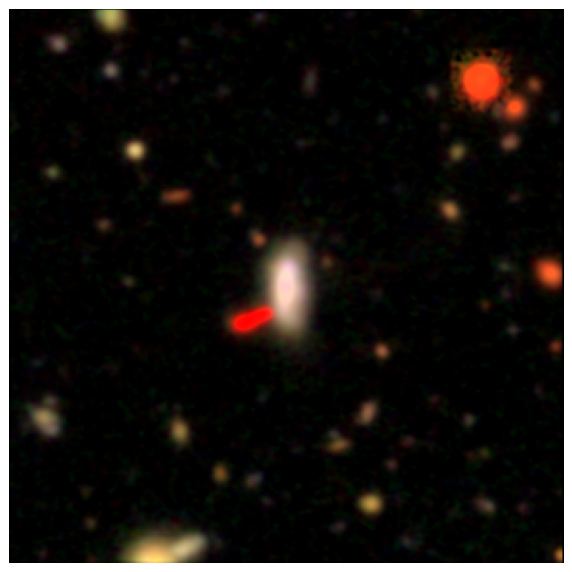

In [77]:
rgb = make_lupton_rgb(cutouts_matched_reproj['i'], #red
                      cutouts_matched_reproj['r'], #green
                      cutouts_matched_reproj['g'], #blue
                      stretch=0.5, Q=5)
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.show()